In [1]:
from sphere.parameters.functional_params import StepFunctionParam

In [2]:
times = [t for t in range(100)]
times

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [3]:
beta = StepFunctionParam(values=[0.3, 0.1])
betas = [beta.get_current_value(t) for t in times]

<Axes: >

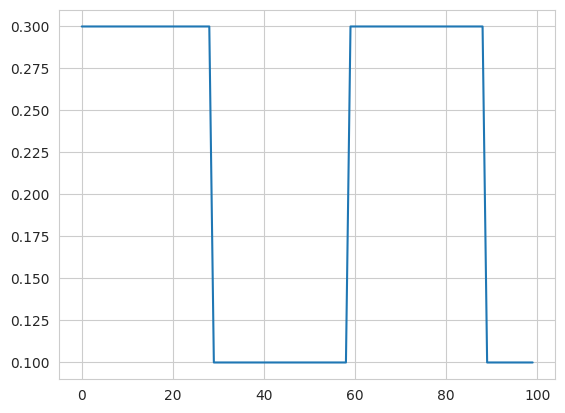

In [4]:
import seaborn as sns

sns.lineplot(x=times, y=betas)

<Axes: >

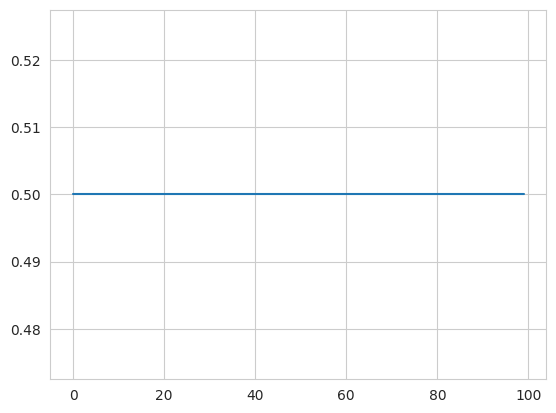

In [5]:
from sphere.parameters.functional_params import ConstantParam

gamma = ConstantParam(value=0.5)
gammas = [gamma.get_current_value(t) for t in times]
sns.lineplot(x=times, y=gammas)

In [6]:
from sphere.model.model_factory import *

ModelFactory.list_model_types()

Available model types:
- SIR: Requires SIRParameters. Can be used with deterministic or stochastic solvers.
- Lorenz63: Requires Lorenz63Parameters. Only supports deterministic solvers.


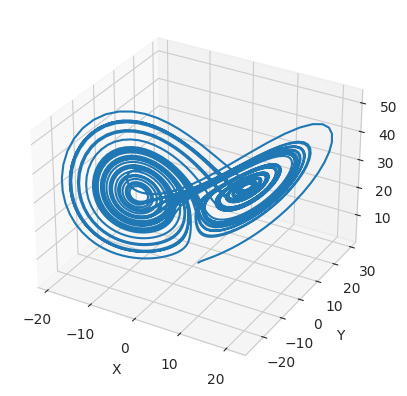

In [7]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

class Parameters:
    def __init__(self, beta: float, sigma: float, rho: float) -> None:
        self.beta = beta
        self.sigma = sigma
        self.rho = rho

class Lorenz63Transition:
    def __init__(self, params: Parameters) -> None:
        self.params = params

    def drift(self, state: jnp.ndarray, t: float) -> jnp.ndarray:
        x, y, z = state
        sigma, rho, beta = self.params.sigma, self.params.rho, self.params.beta
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return jnp.array([dx, dy, dz])

class EulerSolver:
    def __init__(self, transition):
        self.transition = transition

    def step(self, state: jnp.ndarray, dt: float, t: float) -> jnp.ndarray:
        drift = self.transition.drift(state, t) * dt
        return state + drift

class Output:
    def __init__(self, num_steps: int, state_shape):
        self.states = jnp.zeros((num_steps, *state_shape))

    def store(self, state, index):
        self.states = self.states.at[index].set(state)

class Model:
    def __init__(self, solver, output):
        self.solver = solver
        self.output = output

    def _validate_dt(self, dt):
        if dt <= 0:
            raise ValueError("dt must be positive")

    def run(self, x0: jnp.ndarray, t0: int, t_final: int, dt: float):
        self._validate_dt(dt)
        x0 = jnp.array(x0)
        num_output_points = int((t_final - t0) / dt) + 1
        self.output = Output(num_output_points, x0.shape)
        output_times = jnp.arange(t0, t_final + dt, dt)

        state = x0
        current_time = t0
        output_index = 0

        self.output.store(state, output_index)

        for target_time in output_times[1:]:
            while current_time < target_time:
                state = self.solver.step(state=state, dt=dt, t=current_time)
                current_time += dt
            output_index += 1
            self.output.store(state, output_index)

# Parameters and initial state
params = Parameters(beta=8.0 / 3.0, sigma=10, rho=28)
transition = Lorenz63Transition(params)
solver = EulerSolver(transition)
output = Output(5001, (3,))
model = Model(solver, output)

x0 = jnp.array([1.0, 1.0, 1.0])
model.run(x0=x0, t0=0, t_final=50, dt=0.01)

# Plot the results
states = model.output.states

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
